### Risk Model
Below is a high-level return and holdings based risk model. I've generated the results for the BRAGX fund below. If you would like run the code yourself, please clone the repository. I've provided the necessary .pkl files to generate the graphs without rerunning the calculation-intensive code. The results can be recreated by uncommenting the code and running from the top.

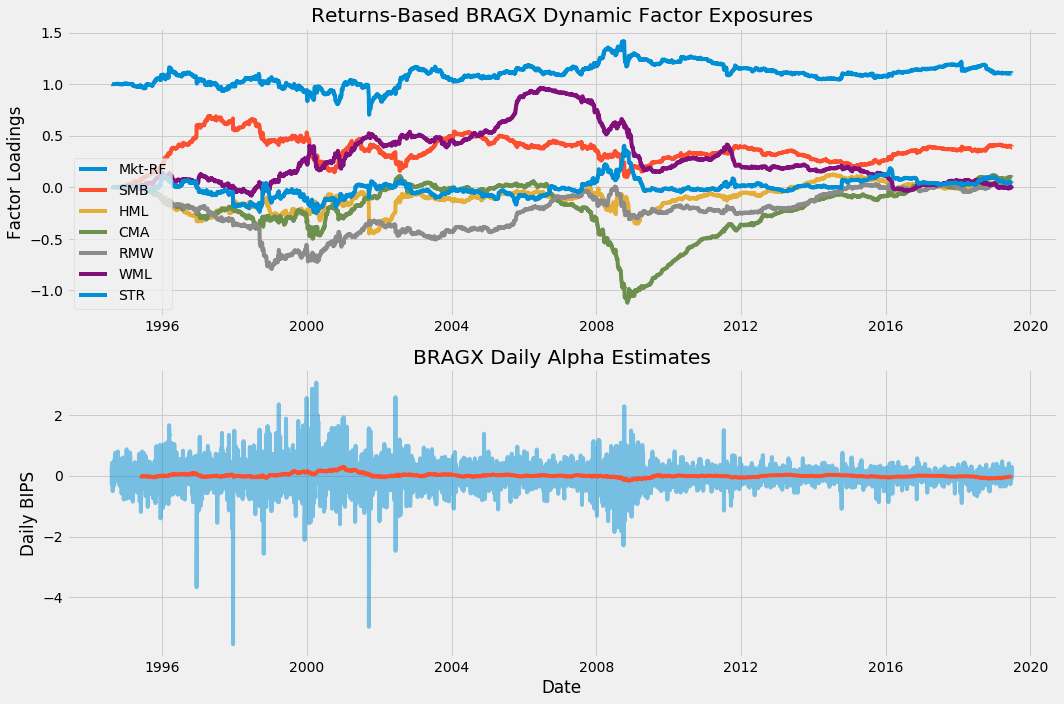

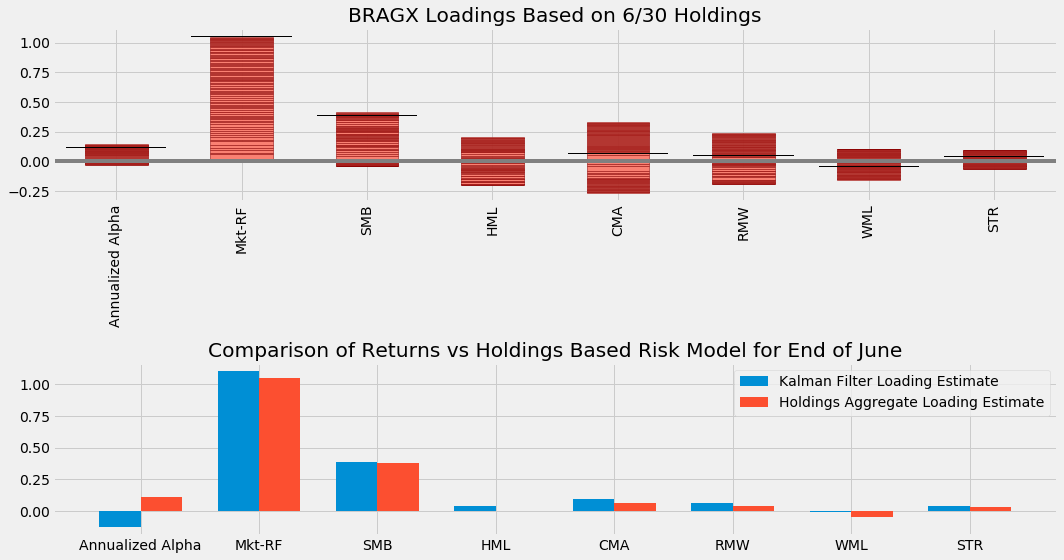

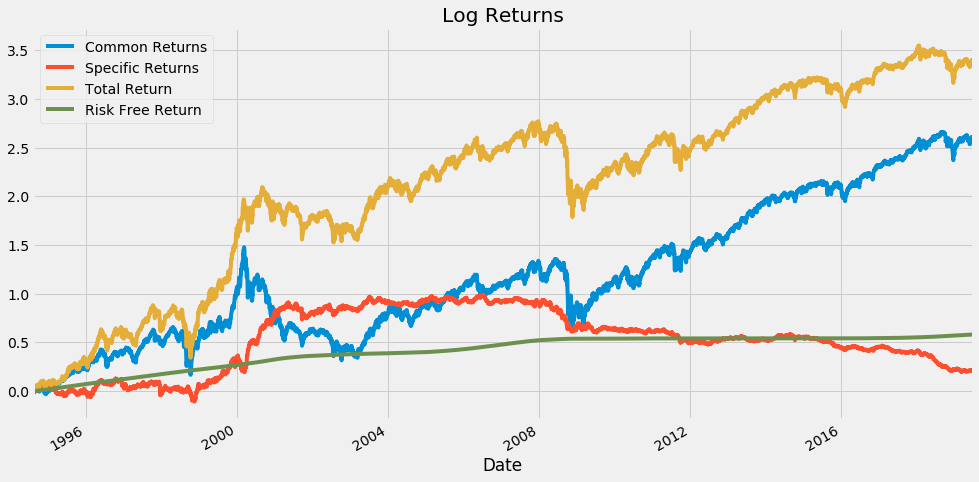

In [62]:
fund = 'BRAGX'
model = 'full'
plot_exposure(fund,model)
estimate_rolling(fund, model)
return_attribution(fund, model)

In [8]:
@interact_manual
def plot_exp(fund=bwmfs,model=models,start_date='1/1/1990',end_date='1/1/2020'):
    plot_exposure(fund,model,start_date,end_date)
    estimate_rolling(fund, model)

interactive(children=(Dropdown(description='fund', options=('BRAGX', 'BRSVX', 'BRUSX', 'BRLIX', 'BOSVX', 'BOTS…

The returns-based risk model generates dynamic factor loadings by utilizing a Kalman filter. A Kalman filter requires a "prior" parameter to be specified. **Note: if the prior is significantly different than the "true" exposure, the model will require a burn-in period before converging to a stable estimate.** Time-varying loadings were estimated using Kalman filters and rolling OLS regressions. The Kalman filters outperformed the rolling regressions and they do not require a rolling-window specification.

### Models
I have included five different model specifications for testing. They are:
- **full**: The Fama French 5 Factor model augmented with momentum and short term reversals.
- **ff3**: The Fama French 3 Factor model.
- **ff5**: The Fama French 5 Factor model.
- **carhart**: The Carhart 4 Factor model.
- **capm**: CAPM model (only includes market beta).

These factors are all sourced from Ken French's website. Alternative formulations of the factors could be easily incorporated, as well as additional factors (such as industry factors).

The fund holdings were sourced from Thomson Reuters Eikon. The fund and equity historical returns were sourced from Yahoo Finance. Historical prices for the options held by the Managed Volatility fund were not available. A handful of stocks could not be mapped from the Eikon-provided symbol to a matching Yahoo Finance equity. Any stock that could not be found was assumed to have a Market beta loading of 1, and 0 factor exposure, consistent with the expected loadings for any randomly picked stock (the total market portfolio has a market beta of 1 with 0 loadings on all other zero-invesment portfolio factors by definition). 

The analysis as it stands is quick-and-dirty demonstration of factor-based return and holdings risk models. The analysis so far is very flexible and could be expanded to include estimates of statistical significance and forecasts for each variable. The initialization parameters for the Kalman filter could be improved through cross-validation. 

# "Run All Below" from this cell first!!!! 
## Double-click here and then select "Cell">"Run All Below" 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import pandas_datareader as pdr
import statsmodels.api as sm
import matplotlib.style as style 
from numpy.lib.stride_tricks import as_strided as stride
from pykalman import KalmanFilter
from scipy import poly1d
from ipywidgets import widgets 
from IPython.display import display, clear_output, Image
from chart_studio.widgets import GraphWidget
import warnings
from matplotlib import colors
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
style.use('fivethirtyeight')
pd.set_option('mode.chained_assignment', None)

<IPython.core.display.Javascript object>

In [3]:
# ff = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench',start='1/1/1990')

# ff_m = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start='1/1/1990')
# ff_st = web.DataReader('F-F_ST_Reversal_Factor_daily','famafrench',start='1/1/1990')
# ff_i = web.DataReader('10_Industry_Portfolios_daily','famafrench',start='1/1/1990')

# ff = ff[0]

# ff = ff.join(ff_m[0]).join(ff_st[0]).join(ff_i[0])
# ff /= 100

# ff.to_pickle('ff.pkl')

bwmf = {'BRAGX':'Aggressive Investors 1',
       'BRSGX':'Small-Cap Growth',
       'BRSVX':'Small-Cap Value',
       'BRUSX':'Ultra-Small Company',
       'BRLIX':'Blue Chip',
       'BOSVX':'Omni Small-Cap Value',
       'BOTSX':'Omni Tax-Managed Small-Cap Value',
       'BRISX':'Ultra-Small Company Market'}


# holdings = None
# for key in bwmf:
#     df = pd.read_excel(f'{key}.xlsx', header=3)
#     df['fund'] = key
#     df['symbol'] = df['RIC'].apply(strip)
#     if isinstance(holdings, type(None)):
#         holdings = df
#     else:
#         holdings = holdings.append(df,ignore_index=True)

# syms = [x for x in holdings.symbol.unique().tolist() if len(x) <= 5]

# dfs.to_pickle('stocks.pkl')

# warnings.filterwarnings(action="ignore", message="unclosed", category=ResourceWarning)
# stocks = []
# i = 0
# length = len(syms)
# for port in np.array_split(syms,length//2):
#     try:
#         df = web.DataReader(port,'yahoo',start='1/1/2015')['Adj Close']
#         stocks.append(df)
#         i += 1
#         print(f'{i} out of {length//2}', end='\r')
#     except:
#         try:
#             df = web.DataReader(port,'yahoo',start='1/1/2015')['Adj Close']
#             stocks.append(df)
#             i += 1
#             print(f'{i} out of {length//2}', end='\r')
#         except:
#             print(f'failed on {i}')


# dfs = None
# for df in stocks:
#     if isinstance(dfs, type(None)):
#         dfs = df
#     else:
#         dfs = dfs.join(df)

bwmfs = list(bwmf.keys())
# yahoo did not return values for these funds
bwmfs.remove('BRSGX')
bwmfs.remove('BRISX')


# bridgeway = None
# for fund in bwmfs:
#     print(fund)
#     df = web.DataReader(fund,'yahoo',start='1/1/1990')['Adj Close']
#     df.name = fund
#     if isinstance(bridgeway, type(None)):    
#         bridgeway = pd.DataFrame(df)
#     else:
#         bridgeway = bridgeway.join(df, how='outer')

# rets = ff.join(bridgeway)

# rets = rets.dropna(thresh=19)

# x = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML', 'STR', 'NoDur',
#        'Durbl', 'Manuf', 'Enrgy', 'HiTec', 'Telcm', 'Shops', 'Hlth ', 'Utils',
#        'Other']
# x.extend(bwmfs)
# rets.columns = x

# rets.to_pickle('rets903.pkl')

fmodels = {'full':['Alpha','Mkt-RF','SMB','HML','CMA','RMW','WML','STR'],
          'ff3':['Alpha','Mkt-RF','SMB','HML'],
          'ff5':['Alpha','Mkt-RF','SMB','HML','CMA','RMW'],
          'carhart':['Alpha','Mkt-RF','SMB','HML','WML'],
          'capm':['Alpha','Mkt-RF']}

models = list(fmodels.keys())
# fund_exposures = None
# for f in bwmfs:
#     for m in fmodels:
#         tdf = time_varying_factors(rets,f,m)
#         if isinstance(fund_exposures, type(None)):
#             fund_exposures = tdf
#         else:
#             fund_exposures = pd.concat([fund_exposures,tdf],ignore_index=True)

# fund_exposures.to_pickle('fund_exposures903.pkl')

# hold_loadings = None
# for mod in fmodels.keys():
#     df = holdings['symbol'].apply(lambda x: estimate_params(x, model=mod, roll=500))
#     df['fund'] = holdings['fund']
#     df['Weight'] = holdings['Weight']
#     df['model'] = mod
#     if isinstance(hold_loadings, type(None)):
#         hold_loadings = df
#     else:
#         hold_loadings = pd.concat([hold_loadings, df])
        

# hold_loadings.to_pickle('hold_loadings.pkl')


In [4]:
def estimate_rolling(fund=bwmfs,model=models):
    fe = fund_exposures
    
    temp = hold_loadings[(hold_loadings['fund']==fund) & (hold_loadings['model']==model)]
    temp['Alpha'] *= 252

    fig, ax = plt.subplots(2, figsize=(15,10))
    
    fes = fe[(fe['fund']==fund)&(fe['model']==model)].iloc[-1][fmodels[model]]
    fes['Alpha'] *= 252
    hold = temp[fmodels[model]].multiply(temp['Weight'],axis=0).sum().values
    N = len(fmodels[model])
    ind = np.arange(N)
    
    labels = [i for i in fmodels[model]]
    labels[0] = 'Annualized Alpha'
    
    ax[1].bar(ind, fes.values, width = .35, label='Kalman Filter Loading Estimate')    
    ax[1].bar(ind + .35, hold, width = .35, label='Holdings Aggregate Loading Estimate')
    
    
    temp[fmodels[model]].multiply(temp['Weight'],axis=0).T.plot.bar(stacked=True, figsize=(15,8),\
                                                                    legend=False, color='salmon',\
                                                                    edgecolor='darkred', ax=ax[0])
    ax[0].axhline(0, color='grey')
    
    ax[0].bar(fmodels[model],0.01,bottom=hold, color='k')
    ax[0].set(title=f"{fund} Loadings Based on 6/30 Holdings")
    ax[0].set_xticklabels(labels)
    ax[1].set_xticks(ind + .35/2)
    ax[1].set_xticklabels(labels)
    ax[1].legend()
    ax[1].set(title="Comparison of Returns vs Holdings Based Risk Model for End of June")
    fig.tight_layout()

def time_varying_factors(rets, fund, model='full'):
    
    warnings.filterwarnings(action="ignore")
        
    if model == 'full':
        factors = ['Mkt-RF','SMB','HML','RMW','CMA','WML','STR'] 
    elif model == 'ff3':
        factors = ['Mkt-RF','SMB','HML']
    elif model == 'ff5':
        factors = ['Mkt-RF','SMB','HML','RMW','CMA']
    elif model == 'carhart':
        factors = ['Mkt-RF','SMB','HML','WML']
    elif model == 'capm':
        factors = ['Mkt-RF']
    
    temp_df = rets[factors + ['RF',fund]]

    temp_df['returns'] = temp_df[fund].pct_change()
    temp_df = temp_df.dropna()

    X = temp_df[factors]
    # X = temp_df['Mkt-RF']
    X = sm.add_constant(X)

    Y = temp_df['returns'] - temp_df['RF']
    
#     df = temp_df.merge(roll(temp_df, 1000).apply(rolling_betas),how='left',left_index=True,right_index=True)
#     coefs = df[df.columns[-8:]].shift(999)
    
    x_r = X
    y_r = Y

    obs_mat_r = np.expand_dims(x_r, axis=1)
    
    dimensions = len(factors) + 1
    
    if model == 'capm':
        ism = [0,1]
    else:
        if fund in ['BOTSX','BRSVX','BOSVX']:
            ism = [0,1,1,.5] + [0]*(dimensions-4)
        elif fund == 'BRUSX':
            ism = [0,1,1] + [0]*(dimensions-3)
        else:
            ism = [0,1] + [0]*(dimensions-2)
    
    delta_r = 1e-2
    trans_cov_r = delta_r / (1 - delta_r) * np.eye(dimensions) # How much random walk wiggles
    obs_mat_r = np.expand_dims(x_r, axis=1)
    kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=dimensions, # y_r is 1-dimensional, (alpha, beta, SMB, HML, RMW, CMA, WML, STR) is 7-dimensional
                      initial_state_mean=ism,
                      initial_state_covariance=np.ones((dimensions, dimensions)),
                      transition_matrices=np.eye(dimensions),
                      observation_matrices=obs_mat_r,
                      observation_covariance=.01,
                      transition_covariance=trans_cov_r)
    state_means_r, _ = kf_r.filter(y_r.values)

    results = kf_r.filter(y_r.values)

    kalman_factors = pd.DataFrame(results[0], columns=['Alpha'] + temp_df.columns[:(dimensions-1)].tolist(), index=temp_df.index)
    kalman_factors['fund'] = fund
    kalman_factors['model'] = model
    kalman_factors = kalman_factors.reset_index()
    return kalman_factors
#     fig = go.Figure()

# #     for i in coefs.columns:
# #         fig.add_trace(go.Scatter(x=coefs.index[::2], y=coefs[i].iloc[::2], mode='lines',name=i))

#     for i in kalman_factors.columns:
#         fig.add_trace(go.Scatter(x=kalman_factors.index[::2], y=kalman_factors[i].iloc[::2], mode='lines',name=i))


#     fig.update_layout(
#         title=go.layout.Title(
#             text=f"{fund} Rolling Time Series Factor Exposures",
#             xref="paper",
#             x=0
#         ))

#     fig.show()

def rolling_betas(df):
#     print(df.shape)
#     print(df)
    X = df[['Mkt-RF','SMB','HML','RMW','CMA','WML','STR']]
    X = sm.add_constant(X)

    Y = df['returns'] - df['RF']
    mod = sm.OLS(Y,X)
    res = mod.fit()
    t = res.params
    t.index = [f"{a}_c" for a in t.index]
    return t

def strip(x):
    if type(x) == str:
#         print(x)
        try: x = x[:x.index('.')]
        except: x = x
        return x
    else:
        return 'BIL'

def roll(df, w, **kwargs):
    v = df.values
    d0, d1 = v.shape
    s0, s1 = v.strides

    a = stride(v, (d0 - (w - 1), w, d1), (s0, s0, s1))

    rolled_df = pd.concat({
        row: pd.DataFrame(values, columns=df.columns)
        for row, values in zip(df.index, a)
    })

    return rolled_df.groupby(level=0, **kwargs)


def plot_exposure(fund=bwmfs,model=models,start_date='1/1/1990',end_date='1/1/2020'):
    fig, ax = plt.subplots(2, figsize=(15,10))
    sd = pd.to_datetime(start_date)
    ed = pd.to_datetime(end_date)
    
    x = fund_exposures[(fund_exposures['fund']==fund)&(fund_exposures['model']==model)][['Date']]
    x = x[(x['Date'] >= sd) & (x['Date'] <= ed)]
    for mod in fmodels[model][1:]:
        
        y = fund_exposures[(fund_exposures['fund']==fund)&(fund_exposures['model']==model)][mod].loc[x.index]
        ax[0].plot(x,y, label=mod)
    ax[0].set(ylabel='Factor Loadings',title=f'Returns-Based {fund} Dynamic Factor Exposures')
    
    ax[0].legend(loc=3)
    ax[1].plot(x, fund_exposures[(fund_exposures['fund']==fund)&(fund_exposures['model']==model)]['Alpha'].loc[x.index] * 100, alpha=.5)
    ax[1].plot(x, (fund_exposures[(fund_exposures['fund']==fund)&(fund_exposures['model']==model)]['Alpha'].loc[x.index] * 100).rolling(200).mean())
    ax[1].set(xlabel='Date', ylabel='Daily BIPS', title=f'{fund} Daily Alpha Estimates')
    fig.tight_layout()

prior = pd.Series(data=[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0],index=['Alpha','Mkt-RF','SMB','HML','WML','CMA','RMW','STR'])

def estimate_params(x, model='ff3',roll=500):
    factors = fmodels[model][1:]
    if x in stocks.columns:
        Y = (stocks[x].pct_change() - rets['RF']).dropna()
        X = rets[factors].loc[Y.index]
        X = sm.add_constant(X)
        X = X.iloc[-roll:]
        Y = Y.iloc[-roll:]
        mod = sm.OLS(Y,X)
        res = mod.fit()
        p = res.params
        p.index = fmodels[model]
        return p
    else:
        return prior[fmodels[model]]

In [60]:
def residual_return(fund='BRAGX',model='full'):
    b = fe[(fe['fund']==fund)&(fe['model']==model)][fmodels[model][1:]]
    a = rets[fmodels[model][1:]].loc[b.index]
    c = a.multiply(b)
    d = rets[fund].pct_change().dropna() - rets['RF']
    d.name = f'{fund}-RF'
    
    residual = d - c.sum(axis=1)
    return d, c, residual, rets['RF'].loc[residual.index]

def return_attribution(fund=bwmfs, model=models):
    a, b, c, d = residual_return(fund, model)

    plt.figure(figsize=(15,8))
    b.sum(axis=1).cumsum().plot(label='Common Returns')
    c.cumsum().plot(label='Specific Returns')
    (b.sum(axis=1)+c +d).cumsum().plot(label='Total Return')
    d.cumsum().plot(label='Risk Free Return')
    plt.legend()
    plt.title('Log Returns')
    plt.show()

# Return to the top and run the cell begining with "@interact_manual"